# Lab 1: Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

ModuleNotFoundError: No module named 'tensorflow'

## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [2]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0, 0.5, 'Net demand of Texas (in MW)')

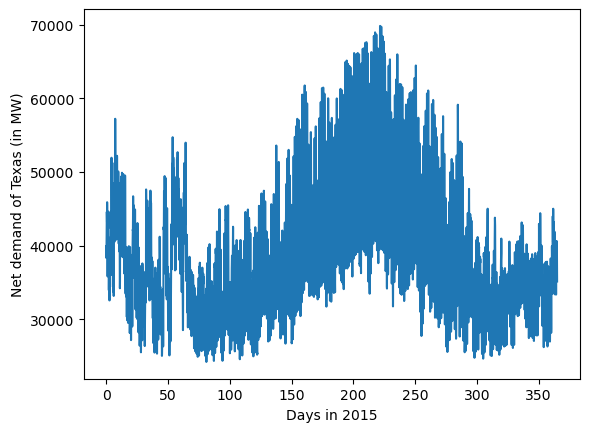

In [3]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (10 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**Your answer.**

Since most of the demand is thermal based, the demand is most likely due to heaters and AC. This means the peak in the graph around 150-250 is AC the summer and the demand near the beginning is from the heater in the winter. The summer looks long and the winter looks short, so from the graph you can infer that Texas has long summers and short winters. Illinois has short summers and long winters, so a graph for Illinois would have a smaller range for the summer portion and a longer portion for the winter.


#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


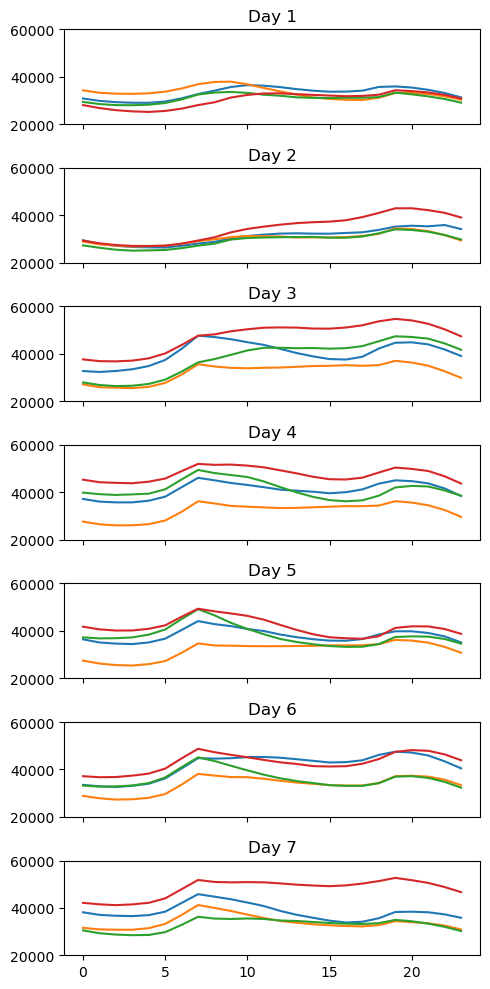

In [4]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (15 points).** Can you find any discernible change in the load profiles of different days of the week? Redo the above exercise for the months of August and September. Make 'Day 1' correspond to August 15th. What do you observe differently? 


**Your answer.**

The first day in the first plot is August 15, 2015.
Day 1  was a  Saturday.


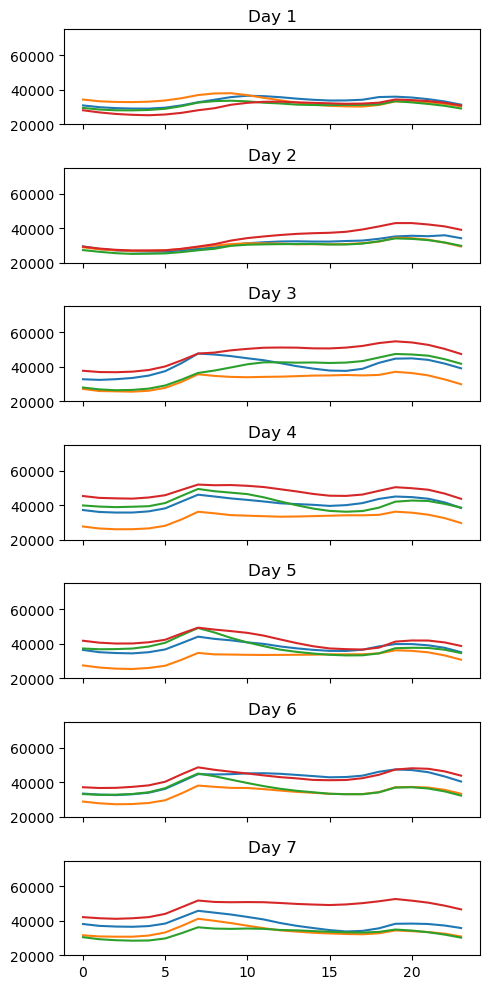

In [5]:
# Modify the following code

# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is August 15, " + str(year) + ".")
print("Day 1", " was a ", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=75000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [6]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [7]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

**Question (25 points). Insert code to design the NN and its optimizer (use the relu function)** 

In [2]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu
inputs = keras.Input(shape=nDimX, name="input")
nn_layer = keras.layers.Dense(nHidden, activation="relu")(inputs)
outputs = keras.layers.Dense(nDimY, name="output")(nn_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code
model.compile(
    optimizer= tf.optimizers.Adagrad(learning_rate=1),
    loss= 'mean_squared_error'
)


NameError: name 'np' is not defined


### Train the neural network via Keras.

Create the training module for the NN. 

Keras is a user-friendly framework to define, train and test neural networks. Check their page out for more details. https://keras.io/ 

Feed the training data in batches of size 'batchSize'.Usually, going through the training data once does not train your NN. You train over the same data multiple times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn a material by reading through it once!

**Question (20 points). Insert code to define the training module**

In [ ]:
batchSize = #
nEpochs = #

# Train the model

print("Fit model on training data")

history = model.fit(
    # insert code
)


### Let us visualize the results.

**Question (5 points). Usine the NN to predict on test data**


In [ ]:
# Output the accuracy of the regressor on the test data.

predictedY = # insert code

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

**Question (10 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**Your answer.**

**Question (15 points).** Fix the number of epochs to your favorite one. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. 

**Your answer (comments here, code below). Your code should show the results for the case with an additional hidden layer. Go back to the codes above for the 1 layer case and run it again for the same number of epochs/neurons**

### The effect of wind energy (bonus).

In [ ]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why?

**Your answer (comments here, code below).**